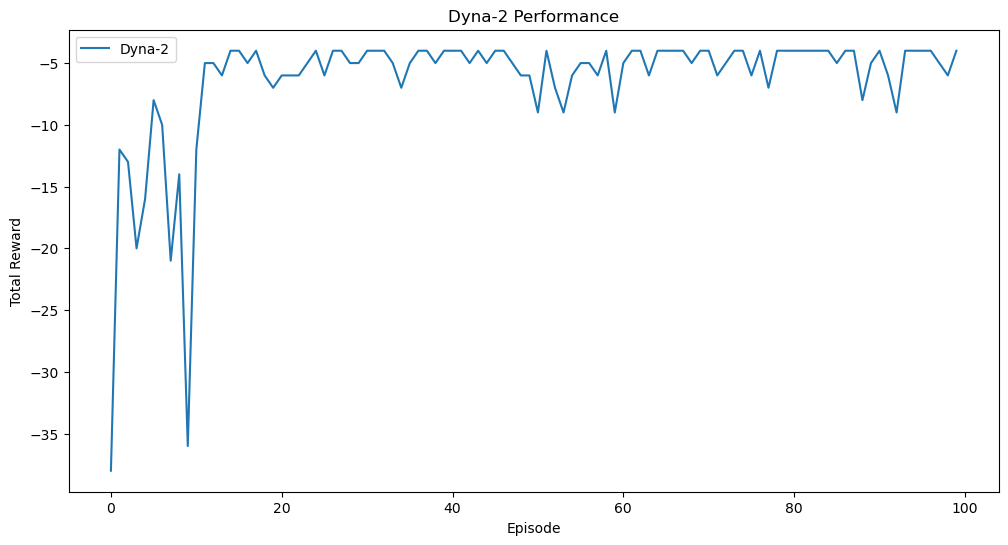

In [1]:
import numpy as np
from collections import defaultdict
import random
import heapq
import matplotlib.pyplot as plt

# 定义环境
class GridWorld:
    def __init__(self, width, height, goal, obstacles, max_steps=1000):
        self.width = width
        self.height = height
        self.goal = goal  # 目标位置 (x, y)
        self.obstacles = obstacles  # 障碍物列表 [(x1, y1), (x2, y2), ...]
        self.actions = ['up', 'down', 'left', 'right']  # 可能的动作
        # 定义动作空间
        class ActionSpace:
            def __init__(self, actions):
                self.actions = actions
                self.n = len(actions)
        self.action_space = ActionSpace(self.actions)
        self.steps = 0
        self.max_steps = max_steps

    def reset(self):
        # 固定初始位置为 (0, 0)
        self.agent_pos = (0, 0)
        self.steps = 0
        return (self.agent_pos,)

    def step(self, actionIndex):
        if actionIndex >= len(self.actions):
            raise ValueError("Invalid action index")
        action = self.actions[actionIndex]
        x, y = self.agent_pos
        if action == 'up':
            y = max(y - 1, 0)
        elif action == 'down':
            y = min(y + 1, self.height - 1)
        elif action == 'left':
            x = max(x - 1, 0)
        elif action == 'right':
            x = min(x + 1, self.width - 1)
        else:
            raise ValueError("Invalid action")

        # 检查新位置是否是障碍物
        if (x, y) in self.obstacles:
            x, y = self.agent_pos  # 保持原位置

        self.agent_pos = (x, y)
        self.steps += 1

        # 到达目标则奖励为 1，否则为 -1
        reward = 1 if (x, y) == self.goal else -1
        terminated = (x, y) == self.goal
        truncated = self.steps >= self.max_steps
        info = {}

        return (x, y), reward, terminated, truncated, info
    
    def visualize(self):
        # 创建网格
        grid = np.zeros((self.height, self.width))

        # 标记障碍物
        for obstacle in self.obstacles:
            grid[obstacle[1], obstacle[0]] = -1

        # 标记目标
        grid[self.goal[1], self.goal[0]] = 2

        # 标记初始位置
        grid[0, 0] = 0.5

        # 绘制网格
        plt.imshow(grid, cmap='viridis', interpolation='nearest')
        plt.colorbar()
        plt.title("Grid World")
        plt.show()

# Dyna-2 算法
class Dyna2:
    def __init__(self, env, alpha=0.1, gamma=0.9, n_simulations=5, lambda_=0.9):
        self.env = env
        self.alpha = alpha  # 学习率
        self.gamma = gamma  # 折扣因子
        self.n_simulations = n_simulations  # 每次搜索的模拟次数
        self.lambda_ = lambda_  # Sarsa(λ) 的参数

        # 初始化永久值函数和瞬时值函数
        self.Q_perm = defaultdict(lambda: np.zeros(env.action_space.n))  # 永久值函数
        self.Q_trans = defaultdict(lambda: np.zeros(env.action_space.n))  # 瞬时值函数

        # 初始化环境模型
        self.model = {}  # 模型存储 (state, action) -> (next_state, reward, terminated, truncated)

        # 初始化资格迹
        self.eligibility = defaultdict(lambda: np.zeros(env.action_space.n))

    def reset_Q_trans(self):
        # 重置瞬时值函数
        self.Q_trans = defaultdict(lambda: np.zeros(env.action_space.n))

    def choose_action(self, state, epsilon=0.1):
        # ε-greedy 策略选择动作
        if random.random() < epsilon:
            return random.choice(range(env.action_space.n))  # 返回动作索引
        else:
            # 结合永久值函数和瞬时值函数
            total_q = self.Q_perm[state] + self.Q_trans[state]
            max_q = np.max(total_q)
            candidates = [a for a, q in enumerate(total_q) if q == max_q]
            return random.choice(candidates)  # 返回动作索引

    def update_permanent_value(self, state, action, reward, next_state):
        # 计算 TD 误差
        next_action = self.choose_action(next_state)
        td_error = reward + self.gamma * self.Q_perm[next_state][next_action] - self.Q_perm[state][action]

        # 更新资格迹
        self.eligibility[state][action] += 1

        # 更新永久值函数
        for s in self.Q_perm:
            for a in range(env.action_space.n):
                self.Q_perm[s][a] += self.alpha * td_error * self.eligibility[s][a]
                self.eligibility[s][a] *= self.gamma * self.lambda_

    def monte_carlo_simulation(self, state):
        # 蒙特卡洛模拟生成轨迹
        trajectory = []
        current_state = state
        total_reward = 0

        while True:
            action = random.choice(range(env.action_space.n))  # 随机策略
            if (current_state, action) in self.model:
                next_state, reward, terminated, truncated = self.model[(current_state, action)]
            else:
                break  # 如果模型中没有该状态-动作对，停止模拟

            trajectory.append((current_state, action, reward))
            total_reward += reward
            current_state = next_state

            if terminated or truncated:
                break

        return trajectory, total_reward

    def update_transient_value(self, state):
        # 更新瞬时值函数
        for _ in range(self.n_simulations):
            trajectory, _ = self.monte_carlo_simulation(state)
            
            # 计算每个状态-动作对的实际回报
            G = 0
            for (s, a, r) in reversed(trajectory):
                G = r + self.gamma * G  # 从后向前计算累计回报
                self.Q_trans[s][a] += self.alpha * (G - self.Q_trans[s][a])

    def learn(self, num_episodes):
        episode_rewards = []

        for episode in range(num_episodes):
            state = self.env.reset()[0]
            done = False
            total_reward = 0
            steps = 0

            # 初始化瞬时值函数
            self.reset_Q_trans()

            while not done:
                action = self.choose_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated

                # 更新永久值函数
                self.update_permanent_value(state, action, reward, next_state)

                # 更新环境模型
                self.model[(state, action)] = (next_state, reward, terminated, truncated)

                # 更新瞬时值函数
                self.update_transient_value(state)

                state = next_state
                total_reward += reward
                steps += 1

            episode_rewards.append(total_reward)
            #print(f"Episode {episode + 1}, Total Reward: {total_reward}")

        return episode_rewards


# 测试 Dyna-2
if __name__ == "__main__":
    # 设置随机种子
    random.seed(42)
    env = GridWorld(width=4, height=4, goal=(3, 3), obstacles=[(1, 1), (2, 2)])

    # 运行 Dyna-2
    dyna_2 = Dyna2(env, n_simulations=20, lambda_=0.99)
    dyna_2_rewards = dyna_2.learn(num_episodes=100)

    # 设置图像大小
    plt.figure(figsize=(12, 6))
    # 绘制累计奖励曲线
    plt.plot(dyna_2_rewards, label="Dyna-2")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Dyna-2 Performance")
    plt.legend()
    plt.show()

d:\anaconda3\envs\py310_torch\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


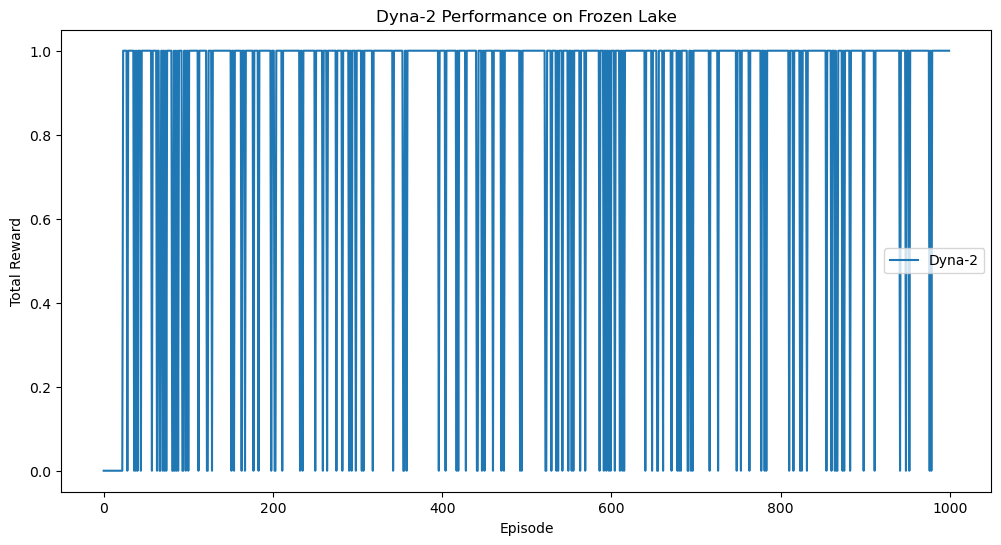

In [2]:
import gym
# 训练Frozen Lake环境
# 创建环境
env = gym.make("FrozenLake-v1", is_slippery=False)
# 创建Dyna-2对象
dyna_2 = Dyna2(env, n_simulations=10, lambda_=0.99)
# 训练Dyna-2
dyna_2_rewards = dyna_2.learn(num_episodes=1000)
# 设置图像大小
plt.figure(figsize=(12, 6))
# 绘制累计奖励曲线
plt.plot(dyna_2_rewards, label="Dyna-2")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Dyna-2 Performance on Frozen Lake")
plt.legend()
plt.show()

In [3]:
# 测试Frozen Lake环境
# 创建环境
env = gym.make("FrozenLake-v1", is_slippery=False, render_mode="human")
for _ in range(10):
    state = env.reset()[0]
    done = False
    while not done:
        action = dyna_2.choose_action(state, epsilon=0.0)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        state = next_state
env.close()

d:\anaconda3\envs\py310_torch\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
